In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from annotationParser import annoParse
import cv2
from tqdm import tqdm_notebook
import random

In [9]:
train_path = './data/chongqing1_round1_train1_20191223/images/'
test_path = './data/chongqing1_round1_testA_20191223/images/'
train_sizes = []
test_sizes = []
for i in tqdm_notebook(os.listdir(train_path)):
    img = cv2.imread(os.path.join(train_path, i), 0)
    train_sizes.append([img.shape[0], img.shape[1]])
    
for i in tqdm_notebook(os.listdir(test_path)):
    img = cv2.imread(os.path.join(test_path, i), 0)
    test_sizes.append([img.shape[0], img.shape[1]])
    
train_sizes = np.array(train_sizes)
test_sizes = np.array(test_sizes)

HBox(children=(IntProgress(value=0, max=4516), HTML(value='')))

HBox(children=(IntProgress(value=0, max=2716), HTML(value='')))

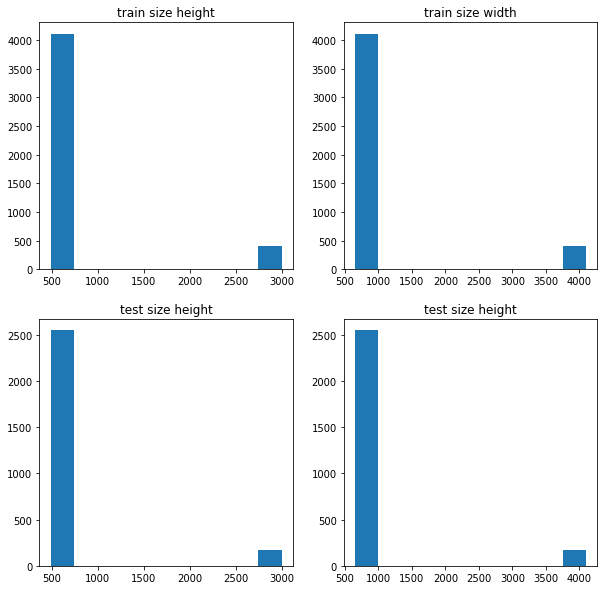

In [15]:
f, ax = plt.subplots(2, 2, figsize = (10, 10))
ax[0, 0].hist(train_sizes[:, 0])
ax[0, 0].set_title('train size height')
ax[0, 1].hist(train_sizes[:, 1])
ax[0, 1].set_title('train size width')
ax[1, 0].hist(test_sizes[:, 0])
ax[1, 0].set_title('test size height')
ax[1, 1].hist(test_sizes[:, 1])
ax[1, 1].set_title('test size height')

Note: bottle train images count is around ~490.  Bottle train images size is ~3000 x 4000  
Now, let's look at labels:

In [16]:
LUT, categories = annoParse('./data/chongqing1_round1_train1_20191223/annotations.json')
print(categories)

{1: '瓶盖破损', 9: '喷码正常', 5: '瓶盖断点', 3: '瓶盖坏边', 4: '瓶盖打旋', 0: '背景', 2: '瓶盖变形', 8: '标贴气泡', 6: '标贴歪斜', 10: '喷码异常', 7: '标贴起皱'}


Let's look at 背景:

In [22]:
LUT.head()

id        file_name  height  width category  \
0   1  img_0017151.jpg     492    658      [2]   
1   2  img_0001675.jpg     492    658      [5]   
2   3  img_0020680.jpg     492    658   [2, 2]   
3   4  img_0015046.jpg     492    658   [9, 2]   
4   5  img_0004341.jpg     492    658      [2]   

                                                bbox  
0       [[165.14, 53.71, 39.860000000000014, 63.29]]  
1  [[465.71, 314.86, 13.580000000000041, 15.27999...  
2  [[364.57, 47.43, 128.43, 35.86000000000001], [...  
3  [[149.14, 238.29, 147.29000000000002, 40.41999...  
4       [[176.57, 48.57, 62.140000000000015, 48.43]]

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

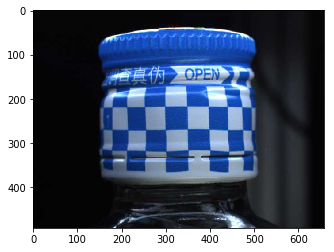

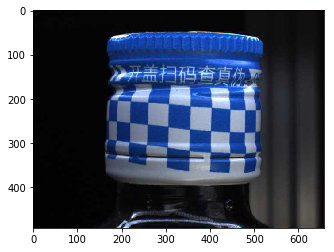

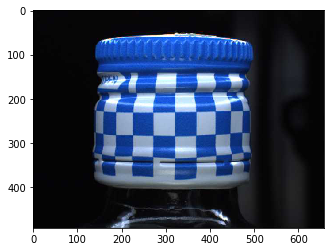

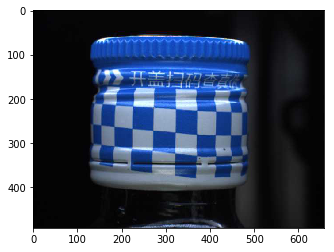

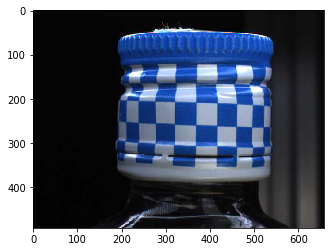

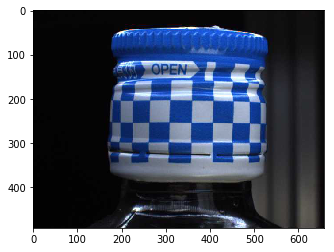

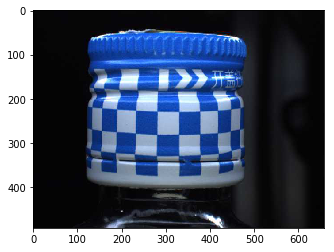

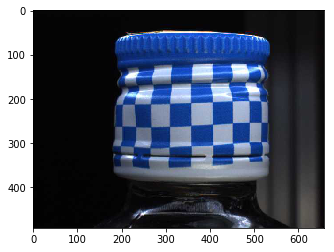

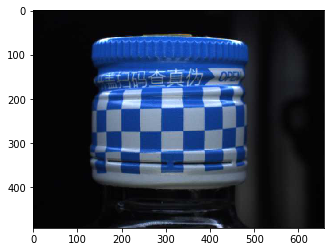

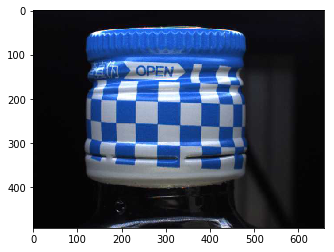

In [28]:
background_imgs = []
for n, i in tqdm_notebook(enumerate(LUT.category)):
    if 0 in i:
        background_imgs.append(LUT.loc[n, 'file_name'])
        
ix = np.random.randint(0, len(background_imgs), 10)
for i in ix:
    img = cv2.imread(os.path.join(train_path, background_imgs[i]), -1)
    plt.imshow(img[:, :, ::-1])
    plt.show()

What does this mean? I don't know.  
Let's look at 6, 标贴歪斜:

In [29]:
sticker_imgs = []
for i in tqdm_notebook(os.listdir(train_path)):
    img = cv2.imread(os.path.join(train_path, i), 0)
    if img.shape[0] > 2000:
        sticker_imgs.append(i)

HBox(children=(IntProgress(value=0, max=4516), HTML(value='')))

In [69]:
tilted = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (6 in LUT.loc[n, 'category']):
        tilted.append(i)
        
untilted = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (6 not in LUT.loc[n, 'category']):
        untilted.append(i)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [62]:
lsd = cv2.createLineSegmentDetector(0)
def findLines(img):
    lines= lsd.detect(img)[0]
    draw = lsd.drawSegments(np.zeros((img.shape[0], img.shape[1])).astype(np.uint8), lines)
    draw = cv2.Sobel(draw, cv2.CV_64F, 0, 1,ksize=5)
    return draw

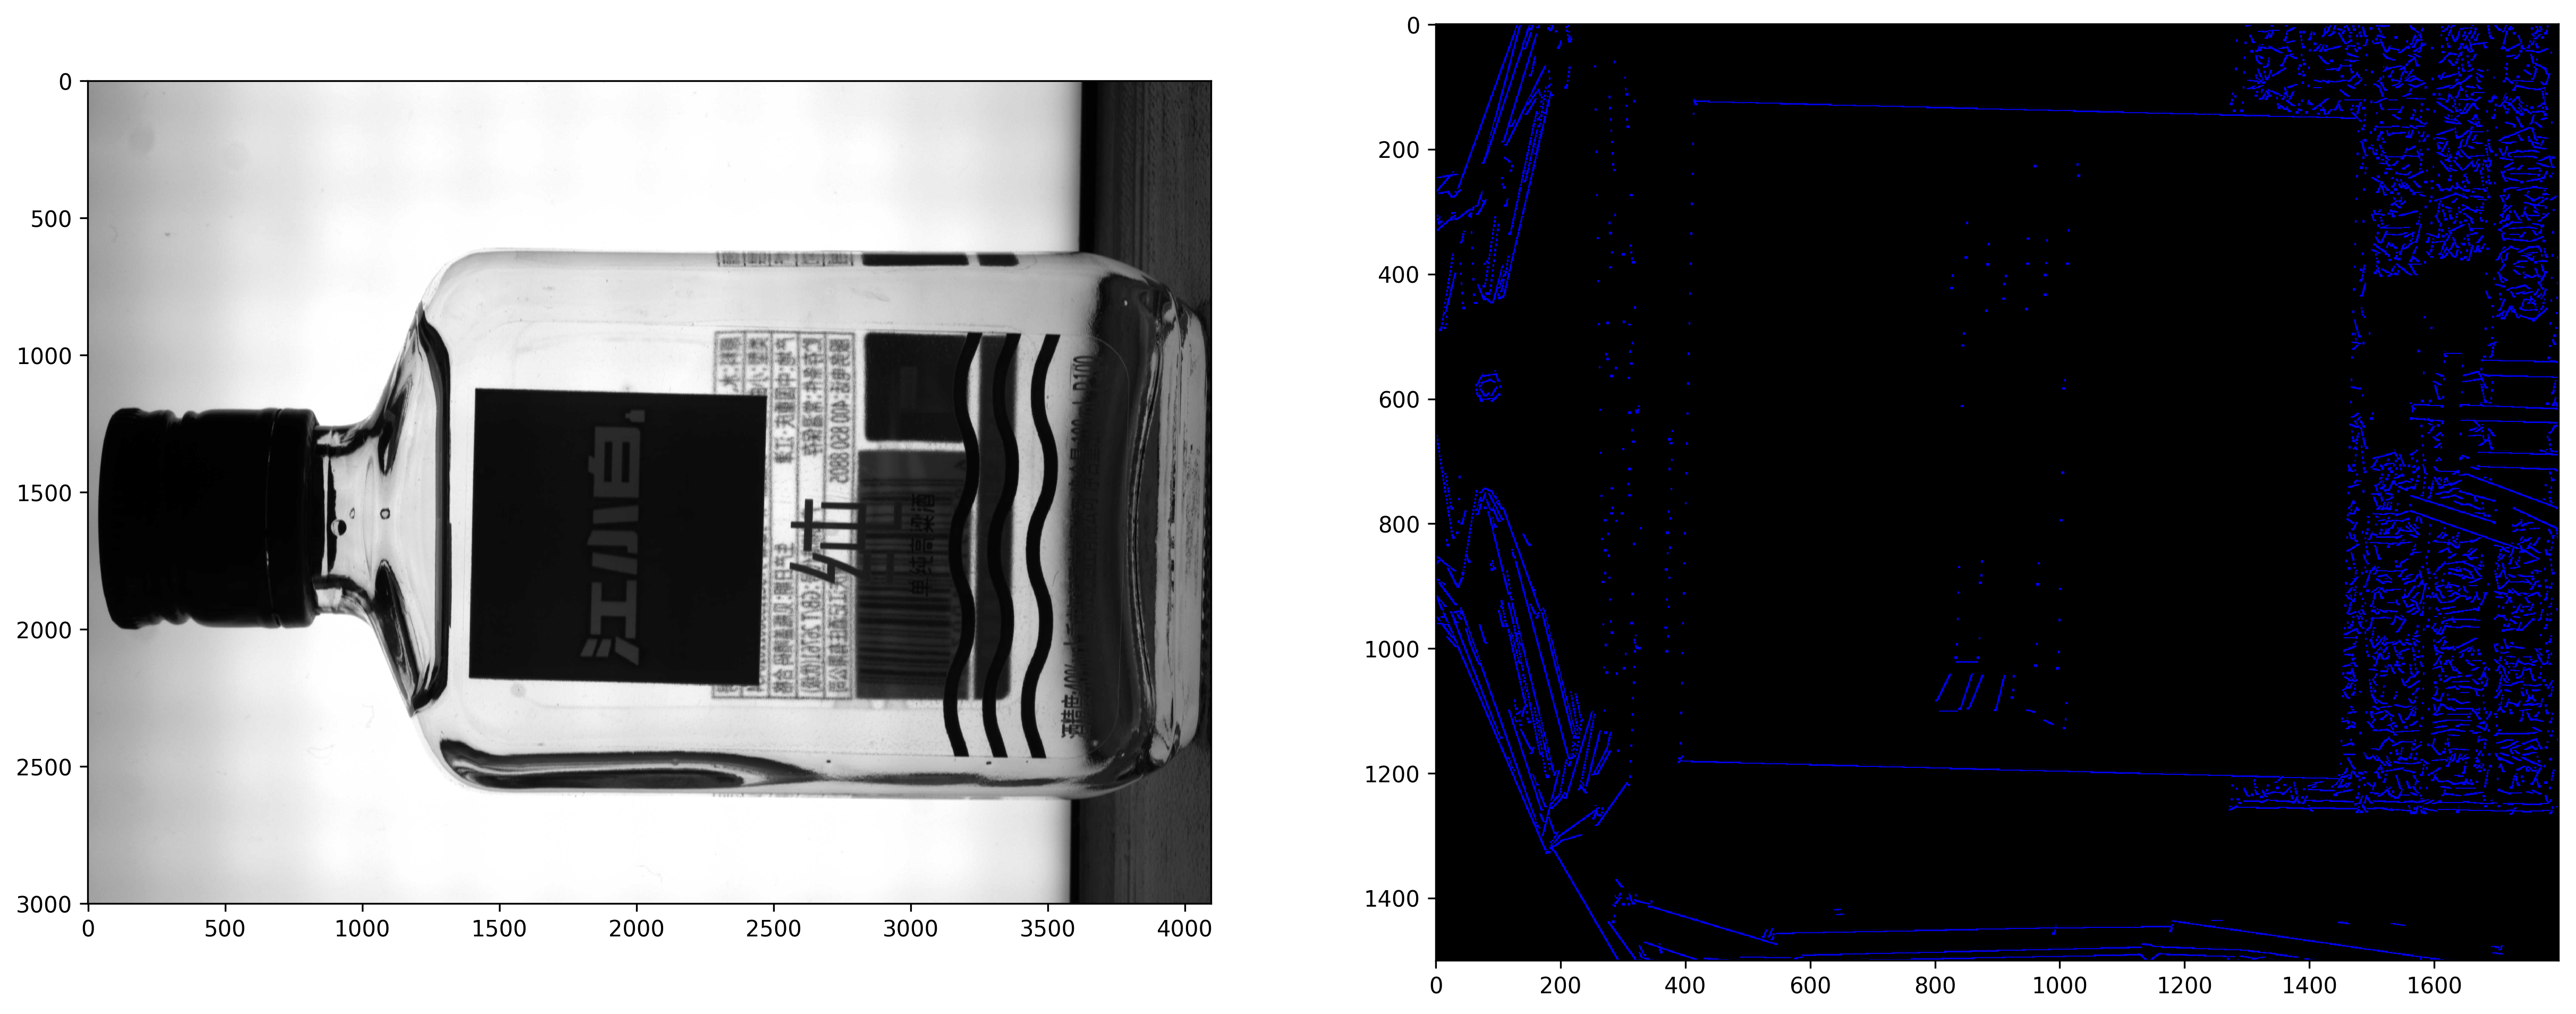

In [68]:
img = cv2.imread(os.path.join(train_path, tilted[0]), 0)
vertical_edges = findLines(img)
f, ax = plt.subplots(1, 2, figsize = (20, 20), dpi = 300)
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(vertical_edges[1000:2500, 1000:2800])

It is very obviouls that the sticker edge is tilted. Let's compare that to the untilted ones:

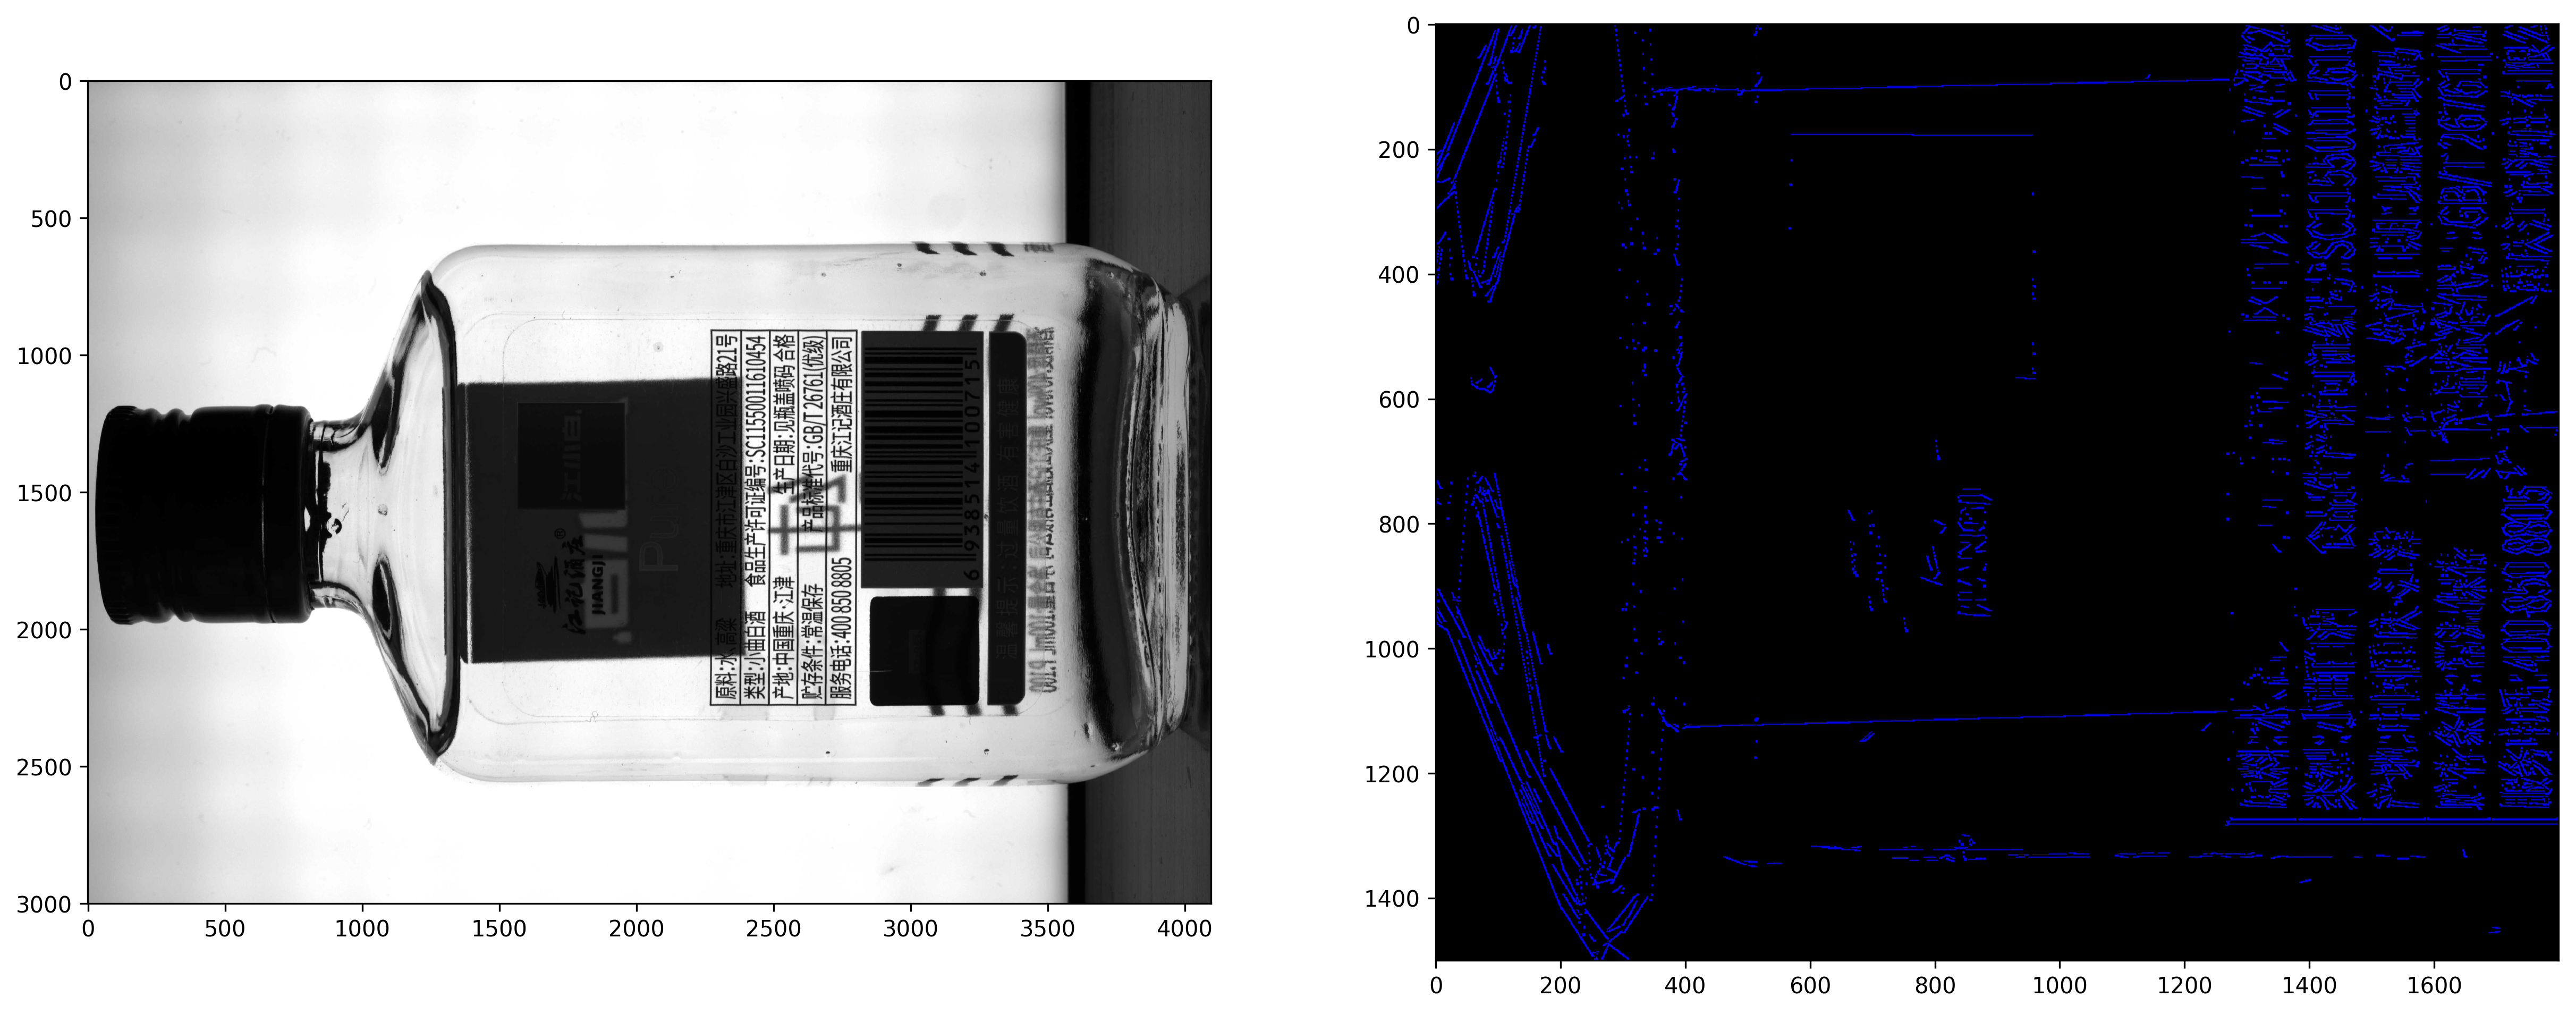

In [75]:
img = cv2.imread(os.path.join(train_path, untilted[50]), 0)
vertical_edges = findLines(img)
f, ax = plt.subplots(1, 2, figsize = (20, 20), dpi = 300)
ax[0].imshow(img, cmap = 'gray')
ax[1].imshow(vertical_edges[1000:2500, 1000:2800])

Let's see the locations:

In [178]:
def drawtiltedbox():
    r = random.sample(tilted, 1)[0]
    ix = np.array(list(LUT[LUT['file_name'] == r].category)[0])
    ix = np.where(ix == 6)[0]
    bbox = np.array(list(LUT[LUT['file_name'] == r].bbox)[0])[ix]
    img = cv2.imread(os.path.join(train_path, r), -1)
    for i in bbox:
        i = [int(x) for x in i]
        cv2.rectangle(img, (i[0], i[1]), (i[0] + i[2], i[1] + i[3]), (255, 0, 0), 20)
    plt.imshow(img)
    plt.show()
    print(len(bbox), r)

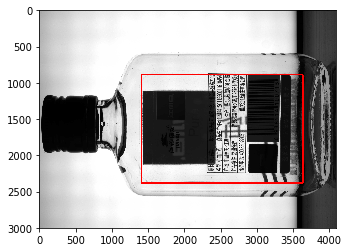

1 img_0002484.jpg


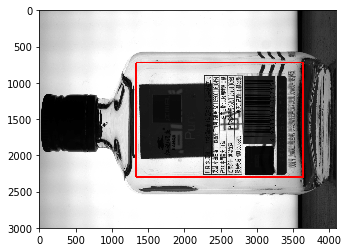

1 img_0024767.jpg


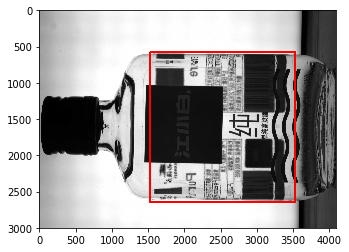

1 img_0001560.jpg


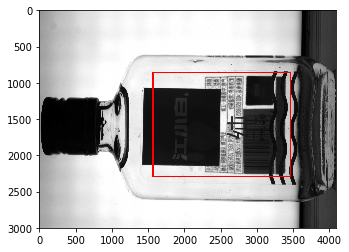

1 img_0005390.jpg


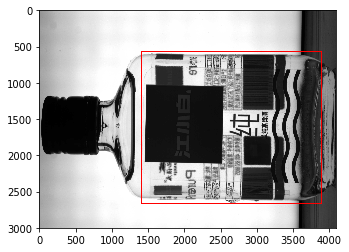

1 img_0019159.jpg


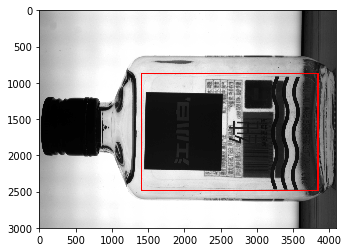

1 img_0008300.jpg


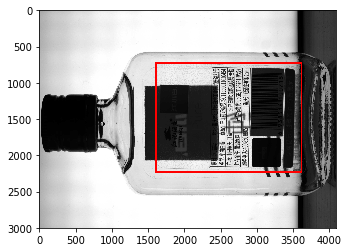

1 img_0008755.jpg


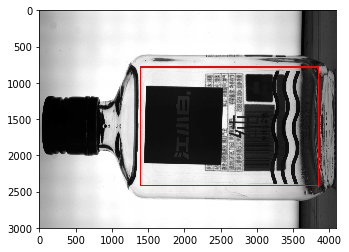

1 img_0006531.jpg


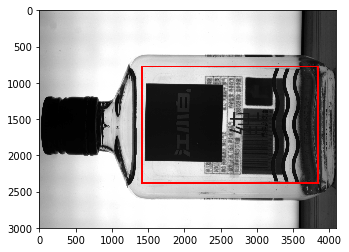

1 img_0018545.jpg


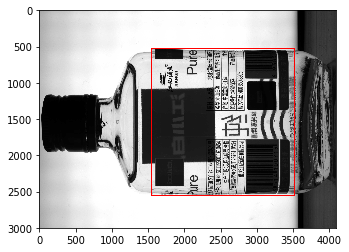

1 img_0006894.jpg


In [179]:
for i in range(10):
    drawtiltedbox()

Next, look at 8: 标贴气泡

In [180]:
bubbled = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (8 in LUT.loc[n, 'category']):
        bubbled.append(i)
        
unbubbled = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (8 not in LUT.loc[n, 'category']):
        unbubbled.append(i)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [181]:
def drawbubblebox():
    r = random.sample(bubbled, 1)[0]
    ix = np.array(list(LUT[LUT['file_name'] == r].category)[0])
    ix = np.where(ix == 8)[0]
    bbox = np.array(list(LUT[LUT['file_name'] == r].bbox)[0])[ix]
    img = cv2.imread(os.path.join(train_path, r), -1)
    for i in bbox:
        i = [int(x) for x in i]
        cv2.rectangle(img, (i[0], i[1]), (i[0] + i[2], i[1] + i[3]), (255, 0, 0), 20)
    plt.imshow(img)
    plt.show()
    print(len(bbox), r)

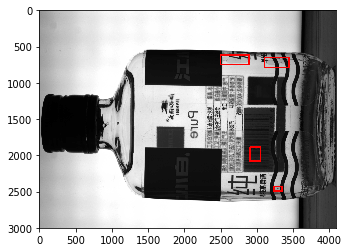

4 img_0006201.jpg


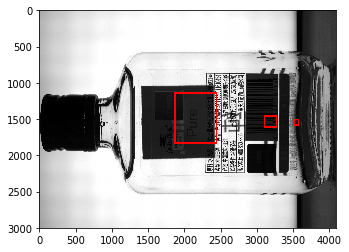

3 img_0009058.jpg


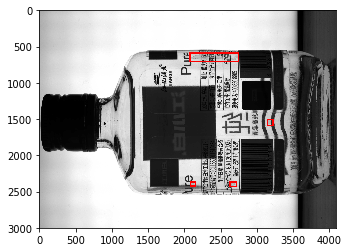

4 img_0003970.jpg


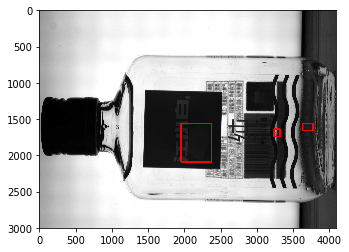

3 img_0015961.jpg


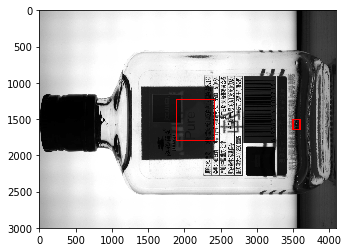

2 img_0023633.jpg


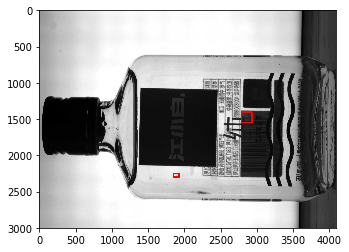

2 img_0022463.jpg


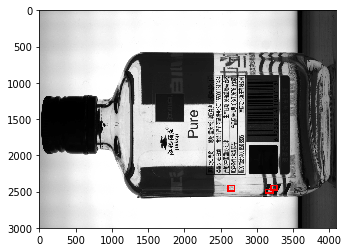

3 img_0013652.jpg


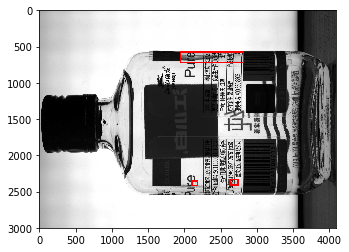

3 img_0029774.jpg


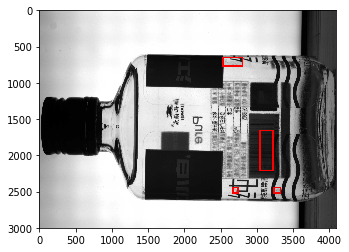

4 img_0019682.jpg


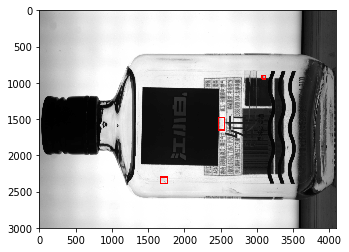

3 img_0024732.jpg


In [183]:
for i in range(10):
    drawbubblebox()

Next, look at 7: 标贴起皱

In [184]:
folded = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (7 in LUT.loc[n, 'category']):
        folded.append(i)
        
unfolded = []
for n, i in tqdm_notebook(enumerate(LUT.file_name)):
    if (i in sticker_imgs) & (7 not in LUT.loc[n, 'category']):
        unfolded.append(i)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [187]:
def drawfoldedbox():
    r = random.sample(folded, 1)[0]
    ix = np.array(list(LUT[LUT['file_name'] == r].category)[0])
    ix = np.where(ix == 7)[0]
    bbox = np.array(list(LUT[LUT['file_name'] == r].bbox)[0])[ix]
    img = cv2.imread(os.path.join(train_path, r), -1)
    for i in bbox:
        i = [int(x) for x in i]
        cv2.rectangle(img, (i[0], i[1]), (i[0] + i[2], i[1] + i[3]), (255, 0, 0), 20)
    plt.imshow(img)
    plt.show()
    print(len(bbox), r)

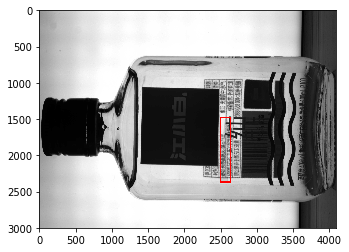

1 img_0008268.jpg


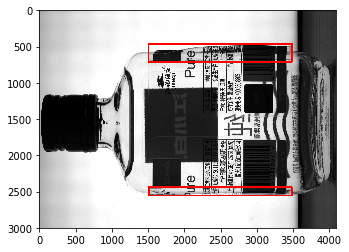

2 img_0005017.jpg


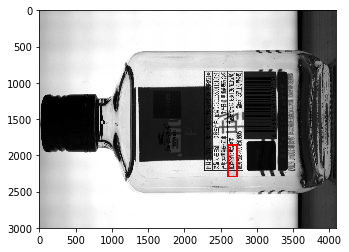

1 img_0011931.jpg


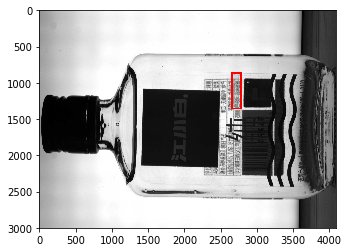

1 img_0015859.jpg


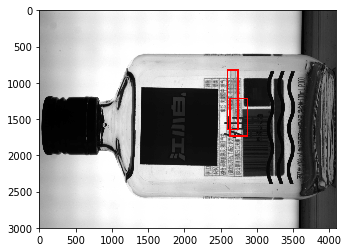

2 img_0006876.jpg


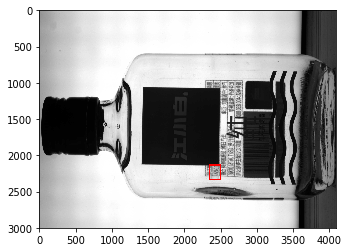

1 img_0006939.jpg


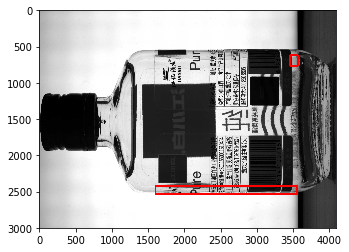

2 img_0004054.jpg


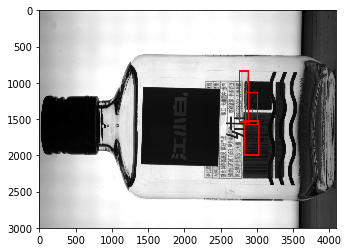

3 img_0010237.jpg


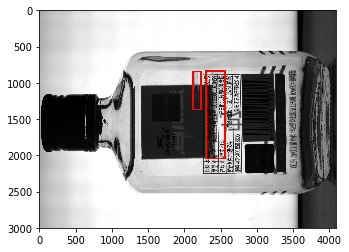

2 img_0029613.jpg


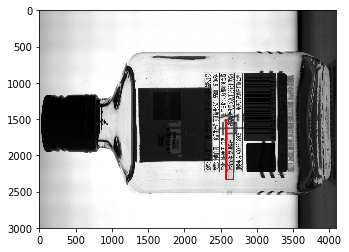

1 img_0017721.jpg


In [188]:
for i in range(10):
    drawfoldedbox()